## Modelling Disease Classification
This notebook runs through our code for building a model that performs image classification on the leaf images, to identify the disease each leaf has.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

### Loading in the training images

In [2]:
train = pd.read_csv("plant-pathology-2020-fgvc7/train.csv")

train_images = []

img_width = 200
img_height = 150
for image_name in train['image_id']: 
    path = "plant-pathology-2020-fgvc7/images/" + image_name + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height),interpolation=cv2.INTER_AREA)
    train_images.append(image)

x_train = np.array(train_images)
x_train = x_train / 255

The pixels of the images are scaled by dividing them with 255. Feeding pixel values between 0 and 1 is better for computational layer to learn and it helps prevent overfitting.

The images are also resized to 200 x 150px.

### Splitting into training and validation set

In [3]:
y = train.drop(columns ='image_id')
y_train = y.to_numpy()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
x_train.shape, x_valid.shape

((1456, 150, 200, 3), (365, 150, 200, 3))

Images are split into 80% training and 20% validation

### Applying SMOTE to solve class imbalance

In [4]:
sm = SMOTE(random_state=42) 

x_train, y_train = sm.fit_resample(x_train.reshape((-1, img_height * img_width * 3)), y_train)
x_train = x_train.reshape((-1, img_height, img_width, 3))
y_train.shape, y_train.sum(axis=0)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


((2008, 4), array([502, 502, 502, 502]))

To prevent our model from underfitting multiple diseases, we oversampled our training data using a method called SMOTE to balance out the class labels.

### Preparing Data Augmentation object

In [5]:
train_gen = ImageDataGenerator(rotation_range=30,
                               zoom_range=0.2,
                               shear_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True)

train_gen.fit(x_train)

### Custom callback method for early stopping

In [6]:
class AccuracyCallback(keras.callbacks.Callback):
    """
    Custom callback method used during training for early stopping. 
    The model will stop training when the accuracy, and validation 
    accuracy threshold have been met or exceeded.
    
    """
    def __init__(self, acc_threshold, val_acc_threshold):
        super(AccuracyCallback, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None): 
        if logs["accuracy"] >= self.acc_threshold and logs["val_accuracy"] >= self.val_acc_threshold:
            self.model.stop_training = True

### Model Definition

In [7]:
model = Sequential()

model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(150, 200, 3), kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=4, activation='softmax'))

adam = keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 200, 32)      2432      
_________________________________________________________________
batch_normalization_9 (Batch (None, 150, 200, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 200, 128)     102528    
_________________________________________________________________
batch_normalization_10 (Batc (None, 150, 200, 128)     512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 100, 128)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 100, 32)       36896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 75, 100, 32)      

For every two convolutional layers, we had a pooling layer which condensed the filtered images to reduce the computation time. At the last convolutional layer, the images were downsized to 13 x 9 px. 

After going through the convolutional layers, the images would go through a flatten layer which converts them into a 1-dimensional array of individual pixels for inputting to the hidden layers of the neural network.

Finally, the model uses SoftMax to generate predictions of how likely each label is.

### Model Training

In [8]:
training_history = model.fit(train_gen.flow(x_train, y_train, batch_size=16), epochs=500, validation_data=(x_valid, y_valid), callbacks=[AccuracyCallback(0.93, 0.97)])

Epoch 1/500
126/126 [==============================] - 15s 110ms/step - loss: 1.9358 - accuracy: 0.3110 - val_loss: 2.0654 - val_accuracy: 0.2740
Epoch 2/500
126/126 [==============================] - 13s 107ms/step - loss: 1.7663 - accuracy: 0.3788 - val_loss: 2.3822 - val_accuracy: 0.2411
Epoch 3/500
126/126 [==============================] - 14s 110ms/step - loss: 1.6416 - accuracy: 0.3930 - val_loss: 4.3088 - val_accuracy: 0.0658
Epoch 4/500
126/126 [==============================] - 14s 107ms/step - loss: 1.6679 - accuracy: 0.3756 - val_loss: 4.0668 - val_accuracy: 0.0767
Epoch 5/500
126/126 [==============================] - 14s 110ms/step - loss: 1.5950 - accuracy: 0.4169 - val_loss: 2.1087 - val_accuracy: 0.2521
Epoch 6/500
126/126 [==============================] - 13s 106ms/step - loss: 1.6140 - accuracy: 0.3935 - val_loss: 1.3841 - val_accuracy: 0.4247
Epoch 7/500
126/126 [==============================] - 14s 111ms/step - loss: 1.5316 - accuracy: 0.4399 - val_loss: 1.4038 -

At the 332th epoch, the model achieved desirable training and validation accuracies. The training process is visualised in the graph below.

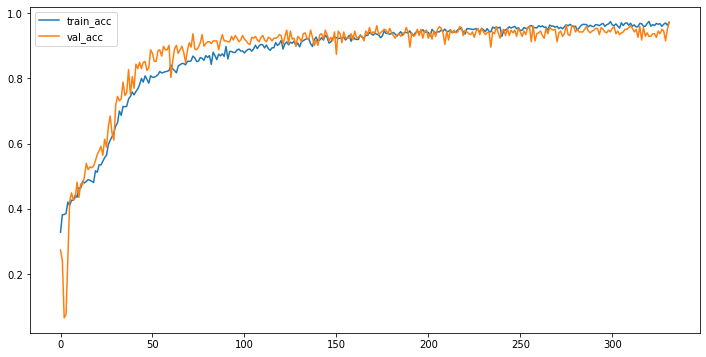

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(training_history.history["accuracy"], label="train_acc")
plt.plot(training_history.history["val_accuracy"], label="val_acc")
plt.legend()

### Model Evaluation on Training Images

Training accuracy: 0.9955179282868526


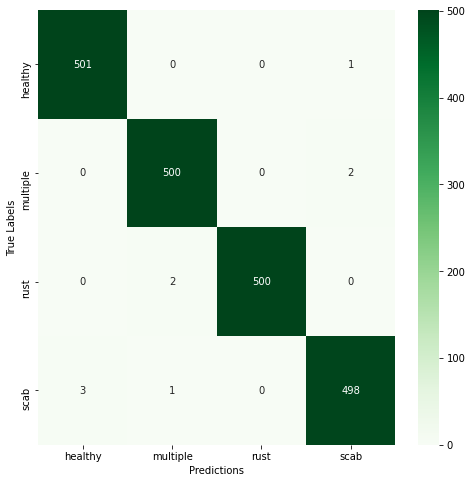

In [10]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(4)])
labels = ['healthy', 'multiple', 'rust', 'scab']
cm = pd.DataFrame(cm , index=labels , columns=labels)

plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, cmap= "Greens", annot=True, fmt='')
ax.set(xlabel='Predictions', ylabel='True Labels')

print("Training accuracy:", accuracy_score(y_true, y_pred))

### Model Evaluation on Test Images

Validation accuracy: 0.9726027397260274


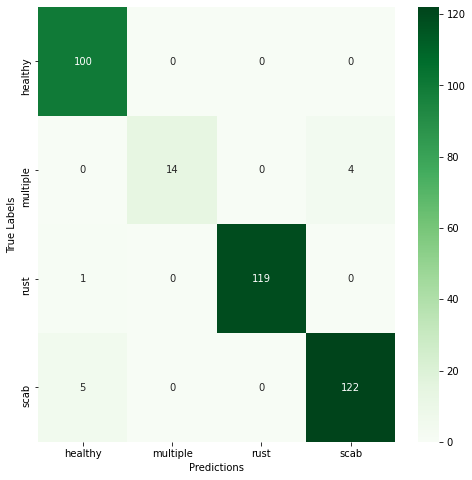

In [11]:
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=[i for i in range(4)])
labels = ['healthy', 'multiple', 'rust', 'scab']
cm = pd.DataFrame(cm , index=labels , columns=labels)

plt.figure(figsize=(8,8))
ax = sns.heatmap(cm, cmap= "Greens", annot=True, fmt='')
ax.set(xlabel='Predictions', ylabel='True Labels')

print("Validation accuracy:", accuracy_score(y_true, y_pred))

Based on the confusion matrixes, the model is very good at predicting healthy leaves, with 100% accuracy in its prediction. It is also performing well in predicting rust and scab leaves, but not as good at predicting leaves with multiple diseases. 

A possible reason for the low accuracy for multiple diseases is that the original training dataset had so few multiple diseases that even with oversampling, our model would struggle to predict this category.

In [12]:
model.save("model.h5")
handler = open("training_history.pickle", "wb")
pickle.dump(training_history.history, handler)